In [690]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

In [691]:
pp_train = pd.read_csv("pp_train.csv")
pp_test = pd.read_csv("pp_test.csv")

pp_class = pp_train.copy()
pp_test_class = pp_test.copy()

### tolgo record con outliers -> no tt

In [692]:
pp_class = pp_class[pp_class["outlier_no_type"] != True]
pp_test_class = pp_test_class[pp_test_class["outlier_no_type"] != True]

### Preprocessing delle variabili

Elimino righe videogame

In [693]:
pp_class = pp_class[pp_class['titleType'] != 'videoGame']
pp_class[['originalTitle', 'titleType']].head(15)

pp_test_class = pp_test_class[pp_test_class['titleType'] != 'videoGame']

Mapping variabile target

In [694]:

y = np.array(pp_class['titleType'])  # Il target originale


# Creiamo un dizionario che associa ogni categoria a un numero
y_map = {title: idx for idx, title in enumerate(pp_class['titleType'].unique())}

#aggiungo una nuova colonna
pp_class['titleType_encoded'] = pp_class['titleType'].map(y_map)
pp_test_class["titleType_encoded"] = pp_test_class['titleType'].map(y_map)

y_map # Per vedere la mappatura delle categorie

{'tvEpisode': 0,
 'movie': 1,
 'tvSeries': 2,
 'tvMiniSeries': 3,
 'short': 4,
 'tvMovie': 5,
 'tvSpecial': 6,
 'video': 7}

##### info variabili

In [695]:
pp_class.columns

Index(['originalTitle', 'rating', 'startYear', 'endYear', 'runtimeMinutes',
       'awardWins', 'numVotes', 'totalImages', 'totalVideos', 'totalCredits',
       'criticReviewsTotal', 'titleType', 'awardNominationsExcludeWins',
       'canHaveEpisodes', 'numRegions', 'userReviewsTotal', 'is_Documentary',
       'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show',
       'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical',
       'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV',
       'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy',
       'is_Family', 'is_Mystery', 'is_Talk-Show', 'is_Drama', 'is_Sport',
       'is_War', 'is_Horror', 'is_Animation', 'is_from_Oceania',
       'is_from_North America', 'is_from_South America', 'is_from_Asia',
       'is_from_Africa', 'is_from_Europe', 'countryOfOrigin',
       'countryOfOrigin_freq_enc', 'countryOfOrigin_NA', 'countryOfOrigin_AF',
       'countryOfOrigin_AS', 'countryOfOrigin_EU',

gestione country of origin  -> già sul train -> codice su modifiche_test

Conversione CanHaveEpisodes in binaria 0/1 (is Adult già binaria)

In [696]:
pp_class['canHaveEpisodes'] = pp_class['canHaveEpisodes'].astype(int)
pp_test_class['canHaveEpisodes'] = pp_test_class['canHaveEpisodes'].astype(int)

Rimuoviamo titleType dato che è già stata mappata + originaltitle e runtimeminutes non filled

In [697]:
column2drop = ['originalTitle', 'runtimeMinutes', 'titleType']
pp_class.drop(column2drop, axis=1, inplace=True)
pp_test_class.drop(column2drop, axis=1, inplace=True)

END YEAR-> tolto finchè non capiamo come gestirlo -> ora commentato nella scelta features

In [698]:
# Riempi i valori mancanti di 'endYear' con quelli di 'startYear' 
# -> DA VEDERE SE GIà SOSTITUITO

#OPPURE RIMUOVI
# pp_class= pp_class.drop(["endYear"], axis=1)
# pp_test_class= pp_class.drop(["endYear"], axis=1)

BINARIZZAZIONE -> TOTALmEDIA E TOTALnOM

In [699]:

#1 binarizzazione (0 / >0) per le variabili con tanti zeri (consigliato per NB)

pp_class['totalNominations_bin'] = (pp_class['totalNominations'] > 0).astype(int)
pp_class['totalMedia_bin'] = (pp_class['totalMedia'] > 0).astype(int)

pp_test_class['totalNominations_bin'] = (pp_test_class['totalNominations'] > 0).astype(int)
pp_test_class['totalMedia_bin'] = (pp_test_class['totalMedia'] > 0).astype(int)


#### altre bin

In [700]:
# #2 discretizzazione per fasce 
# #total media
# bins_tm = [-1, 0, 1, 8, 50, float('inf')]
# labels_tm = [0, 1, 2, 3, 4]  # Mantengo valori numerici per compatibilità con algoritmi
# pp_class['totalMedia_bin'] = pd.cut(pp_class['totalMedia'], bins=bins_tm, labels=labels_tm, right=False)
# pp_test_class['totalMedia_bin'] = pd.cut(pp_test_class['totalMedia'], bins=bins_tm, labels=labels_tm, right=False)

# #total nom
# bins_tnom = [-1, 0, 2, 10,  float('inf')]
# labels_tnom = [0, 1, 2, 3]  # Mantengo valori numerici per compatibilità con algoritmi
# pp_class['totalNominations_bin'] = pd.cut(pp_class['totalNominations'], bins=bins_tnom, labels=labels_tnom, right=False)
# pp_test_class['totalNominations_bin'] = pd.cut(pp_test_class['totalNominations'], bins=bins_tnom, labels=labels_tnom, right=False)

# # # Assicurati che le nuove colonne siano di tipo numerico
# pp_class['totalNominations_bin'] = pp_class['totalNominations_bin'].astype(int)
# pp_test_class['totalNominations_bin'] = pp_test_class['totalNominations_bin'].astype(int)

# pp_class['totalMedia_bin'] = pp_class['totalMedia_bin'].astype(int)
# pp_test_class['totalMedia_bin'] = pp_test_class['totalMedia_bin'].astype(int)



In [701]:
#0>0
# pp_class['awardWins_bin'] = (pp_class['awardWins'] > 0).astype(int)
# pp_class['totalVideos_bin'] = (pp_class['totalVideos'] > 0).astype(int)
# pp_class['awardNominationsExcludeWins_bin'] = (pp_class['awardNominationsExcludeWins'] > 0).astype(int)


# pp_test_class['awardWins_bin'] = (pp_test_class['awardWins'] > 0).astype(int)
# pp_test_class['totalVideos_bin'] = (pp_test_class['totalVideos'] > 0).astype(int)
# pp_test_class['awardNominationsExcludeWins_bin'] = (pp_test_class['awardNominationsExcludeWins'] > 0).astype(int)

#FASCE
# bins_awards = [0, 1, 10, float('inf')]
# labels_awards = [0, 1, 2]  # Mantengo valori numerici per compatibilità con algoritmi
# pp_class['awardWins_bin'] = pd.cut(pp_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)
# ## pp_test_class['awardWins_bin'] = pd.cut(pp_test_class['awardWins'], bins=bins_awards, labels=labels_awards, right=False)



# bins_videos = [0, 1, 6, float('inf')]
# labels_videos = [0, 1, 2]
# pp_class['totalVideos_bin'] = pd.cut(pp_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)
# ## pp_test_class['totalVideos_bin'] = pd.cut(pp_test_class['totalVideos'], bins=bins_videos, labels=labels_videos, right=False)



# bins_nom = [0, 1, 5, float('inf')]
# labels_nom = [0, 1, 2]
# pp_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_class['awardNominationsExcludeWins'], 
#                                                     bins=bins_nom, 
#                                                     labels=labels_nom, 
#                                                     right=False)
# ## pp_test_class['awardNominationsExcludeWins_bin'] = pd.cut(pp_train_class['awardNominationsExcludeWins'], 
# #                                                    bins=bins_nom, 
# #                                                    labels=labels_nom, 
# #                                                    right=False)



# # Assicurati che le nuove colonne siano di tipo numerico
# pp_class['awardWins_bin'] = pp_class['awardWins_bin'].astype(int)
# pp_class['totalVideos_bin'] = pp_class['totalVideos_bin'].astype(int)
# pp_class['awardNominationsExcludeWins_bin'] = pp_class['awardNominationsExcludeWins_bin'].astype(int)

# ## pp_test_class['awardWins_bin'] = pp_test_class['awardWins_bin'].astype(int)
# ## pp_test_class['totalVideos_bin'] = pp_test_class['totalVideos_bin'].astype(int)
# ## pp_test_class['awardNominationsExcludeWins_bin'] = pp_test_class['awardNominationsExcludeWins_bin'].astype(int)


### !! DIVERSO DA GAIA (1,5,6,9)--> Filtra dataset su classi meno rappresentate ->"tvMovie": 7, "tvSpecial":8, "tvShort":9

In [702]:
#pp_class = pp_class[~pp_class['titleType_encoded'].isin([7,8, 9])] # isin([1,5,6,9])]
## pp_test_class = pp_test_class[~pp_test_class['titleType_encoded'].isin([7,8, 9])]

Encoding di titletype per multiclass classification task

In [703]:
# Extract target (y)
y_train = pp_class["titleType_encoded"].values  # Convert directly to NumPy
y_test = pp_test_class["titleType_encoded"].values  # Convert directly to NumPy

####  creazione array di valori -> da cui scegliere feature da usare

In [ ]:
X_train = pp_class[[
       'rating',
       'startYear',  
       'totalCredits', 
       'criticReviewsTotal',
       'canHaveEpisodes', 
       'userReviewsTotal',  
       'countryOfOrigin_freq_enc', 
       'countryOfOrigin_NA',
       'totalMedia_bin',
       'runtimeMinutes_notitletype',
       #'numVotes',
       'numRegions', 
       #'totalNominations_bin',
      
       #'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 

 
       ]].values

X_test = pp_test_class[[ 
       'rating',
       'startYear',  
       'totalCredits', 
       'criticReviewsTotal',
       'canHaveEpisodes', 
       'userReviewsTotal',  
       'countryOfOrigin_freq_enc',
       'countryOfOrigin_NA', 
       'totalMedia_bin',
       'runtimeMinutes_notitletype',
       #'numVotes',
       'numRegions', 
       #'totalNominations_bin',
       #'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
  
       ]].values

In [705]:
# tutte pox
# #       'rating', #cambia poco
#        'startYear',  #forse lasciare
#        #'numVotes', 
#        'totalCredits', 
#        'criticReviewsTotal',
#        'canHaveEpisodes', 
#        #'isAdult', #peggiora molto
#        #'numRegions', 
#        'userReviewsTotal',  
#        'countryOfOrigin_freq_enc',
#        'countryOfOrigin_NA', 
#        #'countryOfOrigin_AF', 'countryOfOrigin_AS', 'countryOfOrigin_EU', 'countryOfOrigin_OC', 'countryOfOrigin_SA','countryOfOrigin_UNK', 
#        #'totalNominations_bin',
#        'totalMedia_bin',
#        'runtimeMinutes_notitletype',

#        #'is_Documentary', 'is_History', 'is_Adventure', 'is_Thriller', 'is_Game-Show', 'is_Comedy', 'is_Sci-Fi', 'is_Romance', 'is_Biography', 'is_Musical', 'is_Western', 'is_Music', 'is_Film-Noir', 'is_Adult', 'is_Reality-TV', 'is_News', 'is_Action', 'is_Crime', 'is_Short', 'is_Fantasy', 'is_Family', 'is_Mystery',  'is_Talk-Show', 'is_Drama', 'is_Sport', 'is_War', 'is_Horror','is_Animation', 
# 
#        #'awardNominationsExcludeWins_bin', #-> PEGGIORA ABB
#        #'totalNominations', #bin
#        #'totalMedia', #bin

### Splitting in validation 
##### -> penso su y_train (array valori multilabeled)

In [706]:
X_train2, X_val, y_train2, y_val = train_test_split(
     X_train, y_train, test_size=0.2, random_state=32
)

In [707]:
print(X_train2.shape, X_val.shape, X_train.shape
      , X_test.shape
      )

(12626, 11) (3157, 11) (15783, 11) (5246, 11)


### Normalization

In [708]:
X_train2_log = np.log1p(X_train2)
X_val_log= np.log1p(X_val)

X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)

In [709]:

standardsc = StandardScaler()

        # # Fitta e trasforma il training set in un solo passaggio
X_train2_standardsc = standardsc.fit_transform(X_train2_log)
X_val_standardsc = standardsc.fit_transform(X_val_log)

X_train_standardsc = standardsc.fit_transform(X_train_log)
        # Trasforma il test set (senza rifittare!)
X_test_standardsc = standardsc.transform(X_test_log)

In [710]:
# minmax = MinMaxScaler()

        ## Fitta e trasforma il training set in un solo passaggio
# X_train2_minmax = minmax.fit_transform(X_train2_log)
# X_val_minmax = minmax.fit_transform(X_val_log)

## X_train_minmax = minmax.fit_transform(X_train_log)
        # # Trasforma il test set (senza rifittare!)
# #X_test_minmax = minmax.transform(X_test)



In [711]:
X_train2_tr = X_train2_standardsc
X_val_tr = X_val_standardsc

X_train_tr = X_train_standardsc
X_test_tr = X_test_standardsc

## NAIVE BAYES

In [712]:
clf = GaussianNB()

In [713]:
clf.fit(X_train2_tr, y_train2)

GaussianNB()

Predicting on validation set

In [714]:
y_pred = clf.predict(X_val_tr)
y_pred

array([2, 2, 0, ..., 0, 7, 7], dtype=int64)

In [715]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_val))  

3157
3157


In [716]:
print(set(y_val)) 
print(set(y_pred))  # se qui manca una classe rispetto a sopra vuol dire che non l'ha riconosciuta 

{0, 1, 2, 3, 4, 5, 6, 7}
{0, 1, 2, 3, 4, 5, 6, 7}


In [717]:
print(f"Test accuracy: {accuracy_score(y_val, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

Test accuracy: 0.7313905606588533

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       952
           1       0.81      0.79      0.80      1072
           2       0.91      0.99      0.95       268
           3       0.00      0.00      0.00        26
           4       0.81      0.78      0.79       470
           5       0.04      0.01      0.02       179
           6       0.14      0.03      0.05        31
           7       0.40      0.22      0.28       159

    accuracy                           0.73      3157
   macro avg       0.47      0.46      0.45      3157
weighted avg       0.69      0.73      0.71      3157



In [718]:
clf.predict_proba(X_val_tr)
#prob che un record appartenga alle classi

array([[0.00000000e+00, 0.00000000e+00, 7.58936380e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 6.00674781e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.34717435e-01, 3.44052563e-03, 0.00000000e+00, ...,
        9.49020437e-03, 4.60035734e-02, 4.99840859e-03],
       ...,
       [9.71497785e-01, 4.52621080e-10, 0.00000000e+00, ...,
        2.38124395e-04, 3.47249041e-04, 1.46259350e-02],
       [4.70433846e-01, 9.79881700e-04, 0.00000000e+00, ...,
        4.45569404e-02, 4.95216600e-03, 4.78551216e-01],
       [5.10340221e-05, 3.93767641e-02, 0.00000000e+00, ...,
        3.01443356e-01, 1.91602313e-01, 4.26547631e-01]])

roc test

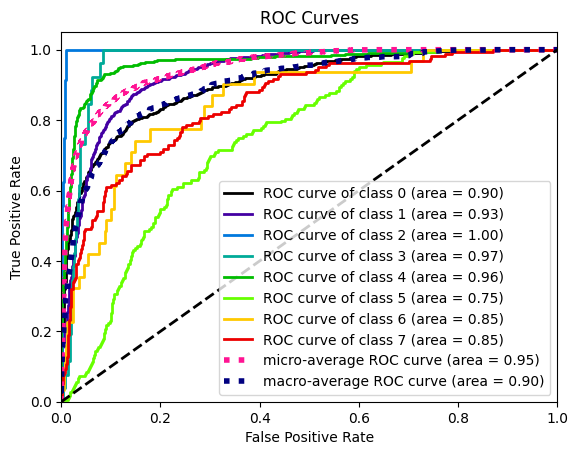

0.902221513518593


In [719]:
plot_roc(y_val, clf.predict_proba(X_val_tr))
plt.show()
print(roc_auc_score(y_val, clf.predict_proba(X_val_tr), multi_class="ovr", average="macro"))

verifica overfitting

Performance sul Training set:
Accuracy: 0.7203
F1 Score: 0.6993

Performance sul Validation set:
Accuracy: 0.7314
F1 Score: 0.7069


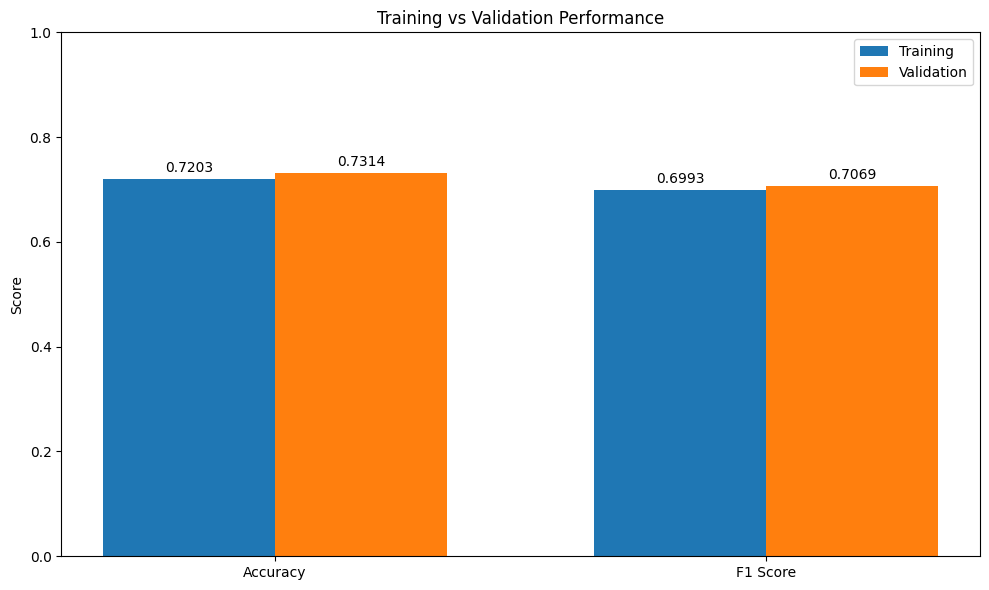

In [720]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train2_tr)
train_accuracy = accuracy_score(y_train2, y_pred_train)
train_f1 = f1_score(y_train2, y_pred_train, average='weighted')

# Valutazione sul validation set
y_pred_val = clf.predict(X_val_tr)
val_accuracy = accuracy_score(y_val, y_pred_val)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul Validation set:")
print(f"Accuracy: {val_accuracy:.4f}")
print(f"F1 Score: {val_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
val_scores = [val_accuracy, val_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, val_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

#### Distribuzioni classi nel train set
- classi con < support sono quelle con performance peggiori
- calitare se togliere classi (togliendo 7,8,9 migliora molto)

In [721]:
class_distribution = pd.Series(y_train2).value_counts().sort_index()

# Mostra i conteggi
print("Distribuzione delle classi nel training set:")
print(class_distribution)

Distribuzione delle classi nel training set:
0    3738
1    4370
2    1069
3     160
4    1912
5     665
6     127
7     585
Name: count, dtype: int64


confusion matrix 

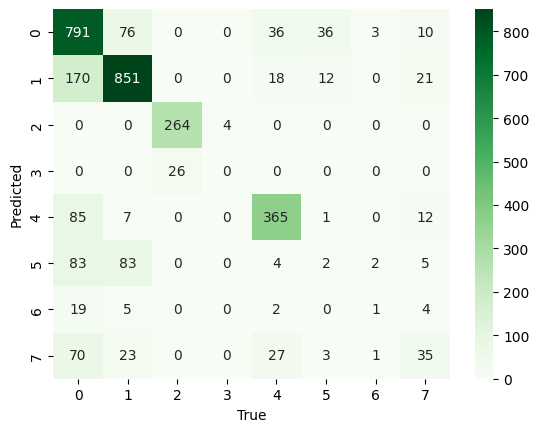

In [722]:
classes_unique = np.unique(y_val)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel("True")
plt.ylabel("Predicted")
plt.show()

# Proper testing on the test set

In [723]:
clf = GaussianNB()
clf.fit(X_train_tr, y_train)
y_pred = clf.predict(X_test_tr)
y_pred
# era y_tpred

array([0, 1, 0, ..., 1, 2, 2], dtype=int64)

In [724]:
print(len(y_pred))  # dovrebbe stampare lo stesso numero in entrambi
print(len(y_test))  

5246
5246


Performance sul Training set:
Accuracy: 0.7227
F1 Score: 0.7009

Performance sul test set:
Accuracy: 0.7310
F1 Score: 0.7098


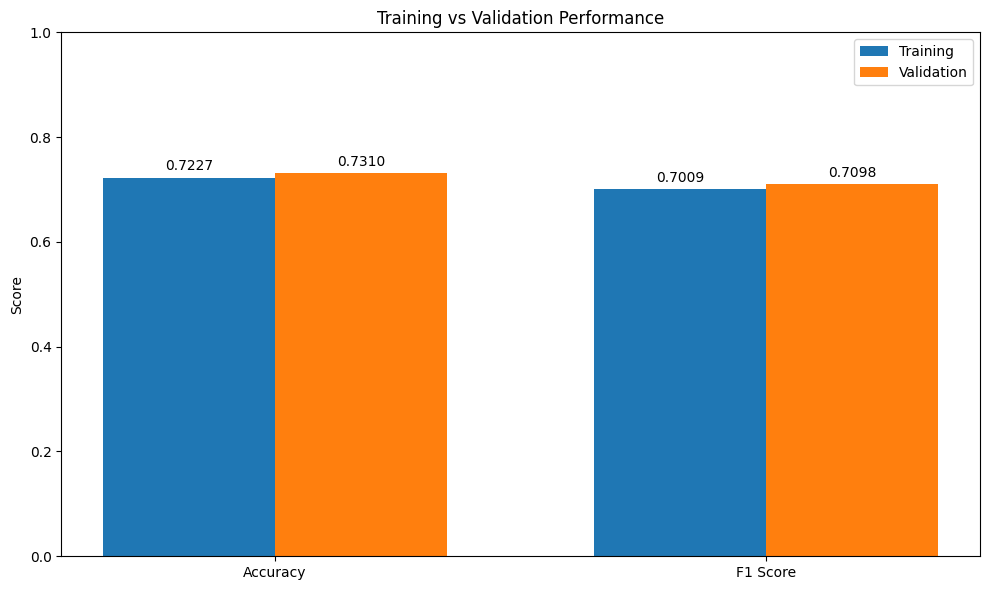

In [725]:
# Importazioni necessarie (se non già importate)
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Valutazione sul training set
y_pred_train = clf.predict(X_train_tr)
train_accuracy = accuracy_score(y_train, y_pred_train)
train_f1 = f1_score(y_train, y_pred_train, average='weighted')

# Valutazione sul test set
y_pred_test = clf.predict(X_test_tr)
test_accuracy = accuracy_score(y_test, y_pred_test)
test_f1 = f1_score(y_test, y_pred_test, average='weighted')
                        ### gaia ha messo y_tpred

# Stampa dei risultati
print(f"Performance sul Training set:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"F1 Score: {train_f1:.4f}")
print("\nPerformance sul test set:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"F1 Score: {test_f1:.4f}")

# Visualizzazione grafica del confronto
metrics = ['Accuracy', 'F1 Score']
train_scores = [train_accuracy, train_f1]
test_scores = [test_accuracy, test_f1]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, train_scores, width, label='Training')
rects2 = ax.bar(x + width/2, test_scores, width, label='Validation')

ax.set_ylabel('Score')
ax.set_title('Training vs Validation Performance')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0, 1)

# Aggiungi i valori sopra le barre
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

In [726]:
print(f"Test accuracy: {accuracy_score(y_test, y_pred)}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Test accuracy: 0.7310331681280976

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.81      0.73      1596
           1       0.82      0.78      0.80      1848
           2       0.87      1.00      0.93       437
           3       0.00      0.00      0.00        68
           4       0.79      0.80      0.79       728
           5       0.10      0.04      0.06       288
           6       0.06      0.02      0.03        42
           7       0.42      0.27      0.33       239

    accuracy                           0.73      5246
   macro avg       0.46      0.47      0.46      5246
weighted avg       0.70      0.73      0.71      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


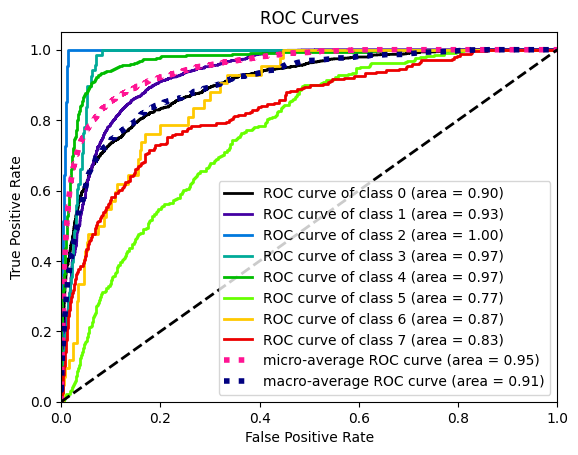

In [727]:
y_test_pred_proba = clf.predict_proba(X_test_tr)
# plot_roc(y_test, y_test_pred_proba)
# plt.show()

import scikitplot as skplt
skplt.metrics.plot_roc(y_test, y_test_pred_proba)
plt.show()

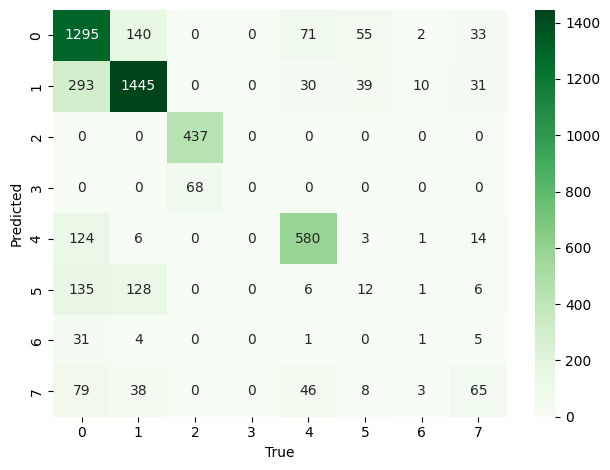

In [728]:
classes_unique = np.unique(y_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes_unique, 
            yticklabels=classes_unique)
plt.xlabel('True')
plt.ylabel('Predicted')
plt.tight_layout()
plt.show()

#### devo cambiare qualcosa?
Compare the results with a dummy classifier 

In [729]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

# Create dummy classifier (most frequent class strategy)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_tr, y_train)

# Predict and evaluate
y_pred = dummy.predict(X_test_tr)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.3522683949675944
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1596
           1       0.35      1.00      0.52      1848
           2       0.00      0.00      0.00       437
           3       0.00      0.00      0.00        68
           4       0.00      0.00      0.00       728
           5       0.00      0.00      0.00       288
           6       0.00      0.00      0.00        42
           7       0.00      0.00      0.00       239

    accuracy                           0.35      5246
   macro avg       0.04      0.12      0.07      5246
weighted avg       0.12      0.35      0.18      5246



C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\noemi\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
